In [1]:
# Reference: https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

## for data
import json
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import re

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, feature_selection, metrics

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lin_menghsien/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lin_menghsien/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# to navigate to the data location
import os

# get current directory 
path = os.getcwd() 

# parent directory
parent = os.path.dirname(path)

df_merge_quality = pd.read_csv(parent + '/data/US_patent_abstract_5000_2015_with_title_1_5y.csv')
df_merge_quality.shape

(5000, 30)

In [3]:
df = df_merge_quality[['text', 'quality_rank']]
df

,text,quality_rank
0,Invitation information push method and system....,0
1,Coronal angulating connector. A connector is p...,0
2,Spearfishing apparatus. A device for spearfish...,1
3,Systems and methods for prioritizing media fil...,1
4,Semiconductor integrated circuit. A semiconduc...,0
...,...,...
4995,Cross-platform cloud-based map creation. Metho...,1
4996,Display substrate. A display substrate include...,1
4997,Aminoquinazoline derivatives and their salts a...,1
4998,Method and device for displaying information i...,1


In [4]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [5]:
# stopwords candidate
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [6]:
df["text_clean"] = df["text"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
df.head()

/home/lin_menghsien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,text,quality_rank,text_clean
0,Invitation information push method and system....,0,invitation information push method system invi...
1,Coronal angulating connector. A connector is p...,0,coronal angulating connector connector provide...
2,Spearfishing apparatus. A device for spearfish...,1,spearfishing apparatus device spearfishing dev...
3,Systems and methods for prioritizing media fil...,1,system method prioritizing medium file present...
4,Semiconductor integrated circuit. A semiconduc...,0,semiconductor integrated circuit semiconductor...


In [7]:
x_train_raw = df['text_clean'][:4000].values
x_dev_raw = df['text_clean'][4000:].values

y_train = df['quality_rank'][:4000].values
y_dev = df['quality_rank'][4000:].values

In [8]:
1 - sum(y_train) / len(y_train) # majority class in train set = 0.58

0.5992500000000001

In [9]:
1 - sum(y_dev) / len(y_dev) # majority class in dev set = 0.576

0.595

In [10]:
x_train_raw[:2]

array(['invitation information push method system invitation information push method includes receiving invitation request sent microblog user server sending invitation information number client corresponding invited user carried invitation request wherein invited user user registered microblog number invited user n greater equal 1 client upon receiving invitation information creating invitation information guide guide user registered microblog register microblog method comprises predetermined time reached server actively sending invitation information least one client corresponding least one user registered microblog',
       'coronal angulating connector connector provided linear implant spinal rod disposed within coronal plane body connector includes first portion first cavity disposal therethrough first spinal rod second portion second cavity disposal therethrough second spinal rod second portion rotatable relative first portion method use disclosed'],
      dtype=object)

In [11]:
y_dev.shape
x_dev_raw.shape

(1000,)

In [12]:
## Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

In [13]:
vectorizer.fit(x_train_raw)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=10000,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [14]:
X_train = vectorizer.transform(x_train_raw)

In [15]:
X_train

<4000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 169635 stored elements in Compressed Sparse Row format>

In [16]:
# vocabulary dictinoary
dic_vocabulary = vectorizer.vocabulary_

Text(0.5, 1, 'Sparse Matrix Sample')

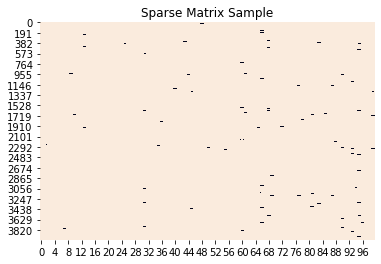

In [17]:
# to visualize its sparsity
sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

In [18]:
# for the time-being, perhaps let's keep entire 10K vocabulary and se the result

In [19]:
# try Naive Bayes classifier

classifier = naive_bayes.MultinomialNB()

In [20]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model.fit(x_train_raw, y_train)


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=10000,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [21]:
## test

predicted = model.predict(x_dev_raw)
predicted_prob = model.predict_proba(x_dev_raw)


In [22]:
print(len(predicted))
predicted

1000


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [27]:
print(predicted_prob.shape)
predicted_prob

(1000, 2)


array([[0.65924349, 0.34075651],
       [0.63890685, 0.36109315],
       [0.54450174, 0.45549826],
       ...,
       [0.26433604, 0.73566396],
       [0.45472964, 0.54527036],
       [0.62479776, 0.37520224]])

In [24]:
# save predicted probability to file for later ensemble model

np.savetxt('Predict_Output/TFIDF_NaiveBayes_5yr_abstract_title_dev_prob.csv', predicted_prob)

Accuracy: 0.6
Auc: 0.521
Detail:
              precision    recall  f1-score   support

           0       0.61      0.94      0.74       595
           1       0.53      0.10      0.17       405

    accuracy                           0.60      1000
   macro avg       0.57      0.52      0.45      1000
weighted avg       0.58      0.60      0.51      1000



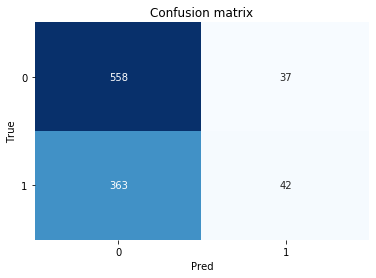

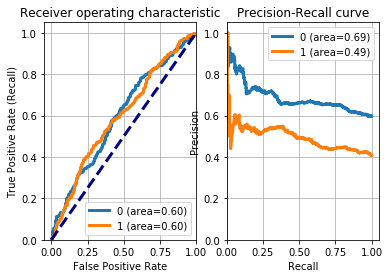

In [26]:
y_test = y_dev

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted)  # predicted_prob), check doc, seems the second argument required to be shape (n_samples,) for binary case 
                            #multi_class="ovr") # check documentation and seems "ovr" not good for only binary target class
print("Accuracy:",  round(accuracy,3))
print("Auc:", round(auc,3))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()